<a href="https://colab.research.google.com/github/DrAlexSanz/micrograd/blob/main/02_Makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of this notebook

* Following Karpathy's 3rd lecture on Makemore

https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=2279

In [72]:
import random
import torch
import torch.nn.functional as F # for laterhttps://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=2279
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-01-05 13:34:51--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2024-01-05 13:34:51 (22.5 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [74]:
words = open("names.txt", "r").read().splitlines()
#words[:8]

In [75]:
len(words)

32033

In [76]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [77]:
# Build the dataset for the NN

block_size = 3 # This is the context lenght. How many characters do I take to predict the next one.

X, Y = [], []

for w in words:
    #print(w)
    context = [0] * block_size

    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print("".join(itos[i] for i in context), "----->", itos[ix])
        context = context[1:] + [ix] # Crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [78]:
# Same thing but in a function
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
# And to see the shapes of what I will input in the NN (X) and the labels (Y)

X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [80]:
# Now I build the embedding layer (Remember it's a matrix multiplication in the end, that acts as a lookup table).
# This is a neural network layer with no non-linearities.
# I have 27 characters (rows) and I will embed them in a 2D vector space (columns). 2 is arbitrary

# Initialize randomly
C = torch.randn((27, 2))
C

tensor([[ 0.0366, -0.0135],
        [-0.9310, -0.9215],
        [-0.4705,  0.4743],
        [ 0.1955, -0.3226],
        [ 0.0717, -1.6041],
        [-1.5572,  0.8368],
        [-1.6316,  1.3239],
        [ 0.0344, -0.9270],
        [ 2.1327, -0.8073],
        [-2.4926, -0.3088],
        [ 0.1667,  0.5229],
        [ 1.7348, -1.4022],
        [ 0.6337,  1.2474],
        [ 1.0583, -0.7238],
        [-0.3534, -0.8935],
        [-0.4380,  1.5585],
        [-1.1278, -2.0757],
        [-0.8642, -0.5864],
        [ 0.6662,  0.4008],
        [-0.4559, -1.5996],
        [ 0.1744,  0.1484],
        [ 0.1369,  0.6544],
        [-0.6576, -1.0545],
        [ 0.6877,  0.5453],
        [-0.0465, -0.0137],
        [ 0.4353, -0.3045],
        [-0.9233,  0.2087]])

In [81]:
# To embed the characters in this space (transform, no training yet) I can just index or matrix multiply them

emb = C[X]
print(emb.shape)
# This will give me the 4th row of the C tensor
print(C[X][3, 2])
print(X[3, 2])
print(C[13])

torch.Size([228146, 3, 2])
tensor([ 1.0583, -0.7238])
tensor(13)
tensor([ 1.0583, -0.7238])


In [82]:
# Now we do the linear layer

W1 = torch.randn(6, 100) # Weights 3 by 2 inputs, 100 neurons
b1 = torch.randn(100)

In [83]:
# However, I can't multiply these matrices just like that. I need first to concatenate the 3D tensor along the second dimension

# What I want is this, but it doesn't scale with the dimension
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim = 1) #Shape should be 32x6

concat = torch.cat((torch.unbind(emb, 1)), dim = 1) # Unbind produces a list as I was doing manually in the previous line. Then I concatenate them and the shape is the same.
# However this is very inefficient. It's copying and creating new object in memeory

In [84]:
# Additionally, there is a better way to do this in this case.

# I can just use view, which is very efficient

#concat_view = emb.view(32, 6) # (32, 3*2) And you can check that the results are the same

In [85]:
#concat_view == concat # It's always True

In [86]:
# So then I calculate the hidden states that I want to pass to the tanh

h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # And this will be 32 x 100

In [87]:
# and the softmax layer

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [88]:
logits = h @ W2 + b2

In [89]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)

In [90]:
# So now for each row of the output, I take the probabilities by indexing

loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(16.6538)

### Let's make this presentable for recap

In [142]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((27, 10), generator = g)
W1 = torch.randn((30, 200), generator = g) # The bottleneck may be the 300 units in the hidden layer OR the 2 dimensional embeddings. I may have to increase to 3, 4, or N dimensional embeddings
b1 = torch.randn((200), generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [143]:
sum(p.nelement() for p in parameters) # Count the number of parameters

11897

### So now, let's use pytorch's functions for optimizing on one batch.
### Later, go up and comment the line where I take the first 5 words of the dataset

In [144]:
# Forward pass
# emb = C[X] # shape is (32, 2, 2)
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # Shape is (32, 100)
# logits = h @ W2 + 2 # Shape is (32, 37)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims = True)
# loss = -prob[torch.arange(32), Y].log().mean()
# loss = F.cross_entropy(logits, Y)
# loss

In [145]:
# Make sure everything that is a parameters accepts gradients
for p in parameters:
    p.requires_grad = True

In [146]:
# Create a vector of learning rates exponentially spaced
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [147]:
lri = [] # For tracking
lossi = [] # For tracking
stepi = []

In [148]:
# Now I add the backward pass and put it in the loop, to optimize only on one batch. I should overfit quickly.

for i in range(200000):

    # build a mini batch. Like this instead of full gradient descent, we have SGD. Iterations are faster but have noise.
    ix = torch.randint(0, Xtr.shape[0], (32,)) # the 32 samples is a tuple

    # Forward pass
    emb = C[Xtr[ix]] # shape is (32, 2, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # Shape is (32, 100)
    logits = h @ W2 + 2 # Shape is (32, 37)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = torch.zeros(p.shape, dtype=torch.float32) # Set them to 0. Apparently python doesn't like None insetad of 0
    loss.backward() # calculate gradients

    # Gradient update stage
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad # lr is 0.1 here

    # track lr and loss
    # lri.append(lre[i]) # Use the exponential version
    stepi.append(i)
    lossi.append(loss.log10().item()) # Nicer plotting



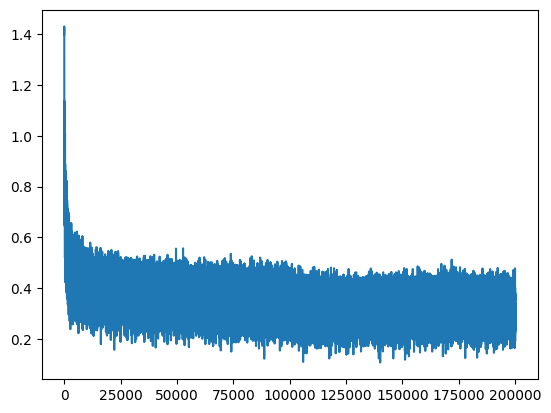

In [149]:
plt.plot(stepi, lossi)

In [150]:
print(loss.item())

2.2626535892486572


In [151]:
# And use the validation set to test it
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4659, grad_fn=<NllLossBackward0>)

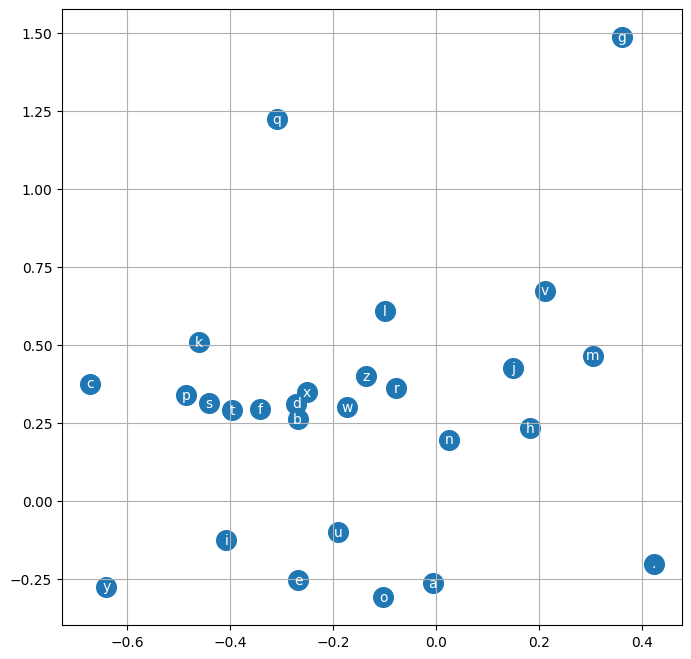

In [127]:
# Visualize the input embeddings. This helps to see if the bottleneck is the embedding dimension
# Only run this with 2D embeddings, or do PCA
plt.figure(figsize = (8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid("minor")
